In [56]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pandas_ta as ta
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

import datetime

In [57]:
def get_data(ticker, start, end):
    data =  yf.download(ticker, progress=True, actions=True,start=start, end=end)
    data = pd.DataFrame(data)
    data.rename(columns = {'Adj Close':ticker}, inplace=True)
    data.drop(['Close', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
    data.dropna(inplace=True)
    
    return data

In [58]:
ticker =  'GOOG'

In [59]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022, 12, 31)

traindf = get_data(ticker, start, end)

[*********************100%%**********************]  1 of 1 completed


In [60]:
start_test = datetime.datetime(2023, 1, 1)
end_test = datetime.datetime(2023, 12, 31)

testdf = get_data(ticker, start_test, end_test)

[*********************100%%**********************]  1 of 1 completed


In [61]:
train_dates = traindf.index
test_dates = testdf.index

In [62]:
sc_single = MinMaxScaler(feature_range=(0,1))
sc_mult = MinMaxScaler(feature_range=(0,1))

sc_single.fit_transform(np.array(testdf[ticker]).reshape(-1, 1))

array([[0.05227475],
       [0.03461199],
       [0.        ],
       [0.02479941],
       [0.03621777],
       [0.04406781],
       [0.09794834],
       [0.09170394],
       [0.10758261],
       [0.09616425],
       [0.0893845 ],
       [0.12738636],
       [0.22319357],
       [0.25762711],
       [0.22194469],
       [0.17769857],
       [0.22105271],
       [0.24870651],
       [0.19946473],
       [0.23371996],
       [0.2615522 ],
       [0.39304197],
       [0.3291704 ],
       [0.29794829],
       [0.37948261],
       [0.23603927],
       [0.15504016],
       [0.14433546],
       [0.14683322],
       [0.1459411 ],
       [0.18429973],
       [0.16074934],
       [0.13951826],
       [0.0942017 ],
       [0.0897414 ],
       [0.07671726],
       [0.04603035],
       [0.05941126],
       [0.06297958],
       [0.06672622],
       [0.09884032],
       [0.12934877],
       [0.15718115],
       [0.13202498],
       [0.14058882],
       [0.10508485],
       [0.07564683],
       [0.087

In [63]:
def feature_extraction(data):
    for leng in [10,20,30]:
            sma = ta.sma(data[ticker], length=leng)
            data['SMA_'+f'{leng}'] = [1 if sma[i] < data[ticker][i] else 0 for i in range(len(sma))]

    data['RSI_'+f'{14}'] = ta.rsi(data[ticker])
    stoch = ta.stoch(data['High'], data['Low'], data[ticker])
    stochk = stoch['STOCHk_14_3_3']
    data = data[13:]
    data['Stoch_Oscillator'] = stochk

    williams_r = ta.willr(data['High'], data['Low'], data[ticker])
    data['Williams_%R'] = williams_r

    adx = ta.adx(data['High'], data['Low'], data[ticker])
    data['ADX'] = adx.ADX_14

    features = [col for col in data.columns if col not in ['Open', 'High', 'Low', 'Volume']]

    return data[features].dropna(axis=0)


In [64]:
train = np.array(feature_extraction(traindf))
test = np.array(feature_extraction(testdf))

train = sc_mult.fit_transform(train)
test = sc_mult.fit_transform(test)

/tmp/ipykernel_4130/2752390440.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Stoch_Oscillator'] = stochk
/tmp/ipykernel_4130/2752390440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Williams_%R'] = williams_r
/tmp/ipykernel_4130/2752390440.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [65]:
look_back = 32
num_features = len(train[0])
num_features

8

In [66]:
def preprocess_data(dataset,step):
    X = []
    Y = []
    for i in range(step, len(dataset)):
        X.append(dataset[i-step:i])
        Y.append(dataset[i, 0])

    X, Y = np.array(X), np.array(Y)
    X = np.reshape(X, (X.shape[0], X.shape[1], num_features))
    return X, Y

In [67]:
X_train, y_train = preprocess_data(train, look_back)
X_test, y_test = preprocess_data(test, look_back)

In [68]:
model = Sequential()
model.add(LSTM(units=100,return_sequences=True,batch_input_shape=(32, look_back, num_features)))
model.add(Dropout(0.1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
impl = model.fit(
    X_train,
    y_train,
    validation_split=0.33,
    epochs=100,
    )

Epoch 1/100
57/57 [==============================] - 7s 60ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 2/100
57/57 [==============================] - 2s 41ms/step - loss: 3.3653e-04 - val_loss: 0.0113
Epoch 3/100
57/57 [==============================] - 2s 42ms/step - loss: 2.2905e-04 - val_loss: 0.0104
Epoch 4/100
57/57 [==============================] - 3s 44ms/step - loss: 2.4771e-04 - val_loss: 0.0181
Epoch 5/100
57/57 [==============================] - 3s 47ms/step - loss: 2.3614e-04 - val_loss: 0.0164
Epoch 6/100
57/57 [==============================] - 2s 41ms/step - loss: 3.5866e-04 - val_loss: 0.0149
Epoch 7/100
57/57 [==============================] - 3s 60ms/step - loss: 2.0500e-04 - val_loss: 0.0160
Epoch 8/100
57/57 [==============================] - 3s 51ms/step - loss: 1.7563e-04 - val_loss: 0.0157
Epoch 9/100
57/57 [==============================] - 3s 52ms/step - loss: 1.8766e-04 - val_loss: 0.0124
Epoch 10/100
57/57 [==============================] - 3s 52ms/step -

In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (64, 32, 100)             43600     
                                                                 
 dropout_1 (Dropout)         (64, 32, 100)             0         
                                                                 
 lstm_5 (LSTM)               (64, 32, 100)             80400     
                                                                 
 dropout_2 (Dropout)         (64, 32, 100)             0         
                                                                 
 lstm_6 (LSTM)               (64, 32, 100)             80400     
                                                                 
 dropout_3 (Dropout)         (64, 32, 100)             0         
                                                                 
 lstm_7 (LSTM)               (64, 100)                

In [70]:
impl.history.keys()

dict_keys(['loss', 'val_loss'])

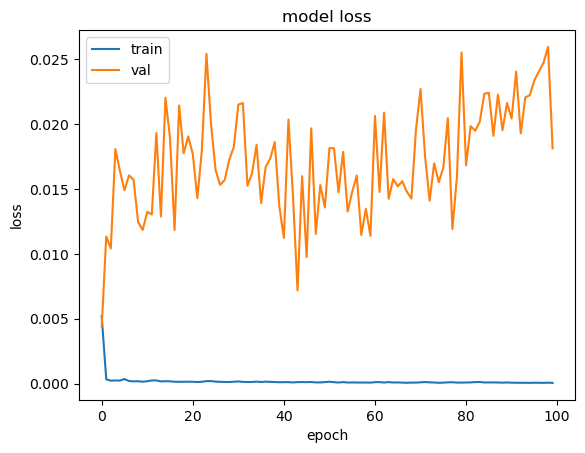

In [71]:
plt.plot(impl.history['loss'])
plt.plot(impl.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [72]:
preds = model.predict(X_test).reshape(-1, 1)
y_pred = sc_single.inverse_transform(preds)
y_test = sc_single.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(np.mean(((y_pred - y_test) ** 2)))
rmse


6/6 [==============================] - 1s 11ms/step


9.665887812208513

In [73]:
y_test.shape

(178, 1)

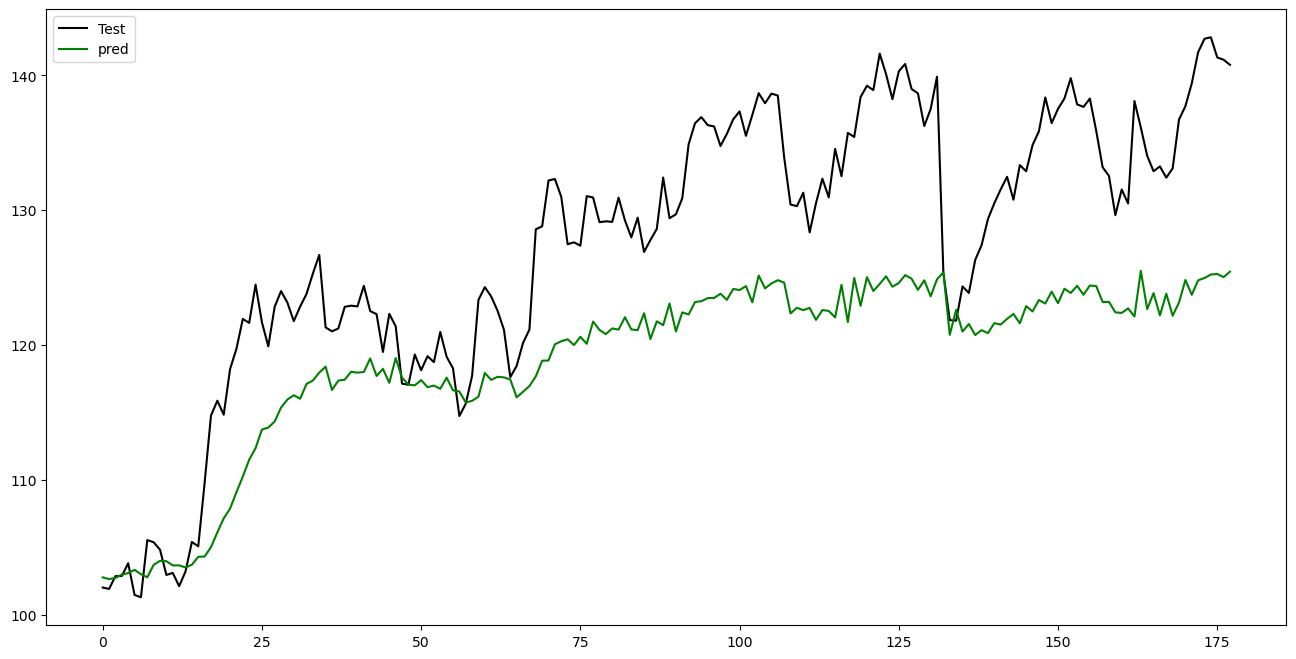

In [74]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()